In [1]:
%cd /Users/Deepthi/Documents/DSE/Q3_DSE220 - Machine Learning/IRI Data - Project/Data/Processed data

/Users/Deepthi/Documents/DSE/Q3_DSE220 - Machine Learning/IRI Data - Project/Data/Processed data


In [2]:
!ls

IRI week translation_2008_2017.csv     IRI week translation_2008_2017.xls
IRI week translation_2008_2017.numbers panel_demo_store_8_11.csv


### Import Libraries

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### Get data

In [4]:
# Panel data from Alex
panel_demo_store_8_11 = pd.read_csv('panel_demo_store_8_11.csv')

In [5]:
# Week translation to get the quarter - I modified this data in excel to include quarter numbers
week_transaltion=pd.read_csv('IRI week translation_2008_2017.csv')

In [6]:
# panel_demo_store_8_11.columns

### Data Clean up

In [7]:
panel_demo_store_8_11 = panel_demo_store_8_11.fillna(0) ## Treat NaN
panel_demo_store_8_11.replace('99',0,inplace=True) ## Treat the extreme value 99 
panel_demo_store_8_11.replace('98',0,inplace=True) ## Treat the extreme value 98
panel_demo_store_8_11 = panel_demo_store_8_11.convert_objects(convert_numeric=True) ## Convert all the columns to numeric values
panel_demo_store_8_11 = panel_demo_store_8_11.fillna(0) ## Replace NaNs
panel_demo_store_8_11['age_group_applied_to_male_hh'].replace(7,0,inplace=True) ## Convert the extreme value 7 to 0 to keep NAs consistent
panel_demo_store_8_11['age_group_applied_to_female_hh'].replace(7,0,inplace=True) ## Convert the extreme value 7 to 0 to keep NAs consistent

### Create 'Day of the week' flag

In [8]:
mon = pd.DataFrame(zip(range(0,1440),['01_Monday']*1440,range(0,1440)))
tue = pd.DataFrame(zip(range(1440,1440*2),['02_Tuesday']*1440,range(0,1440)))
wed = pd.DataFrame(zip(range(1440*2,1440*3),['03_Wednesday']*1440,range(0,1440)))
thu = pd.DataFrame(zip(range(1440*3,1440*4),['04_Thursday']*1440,range(0,1440)))
fri = pd.DataFrame(zip(range(1440*4,1440*5),['05_Friday']*1440,range(0,1440)))
sat = pd.DataFrame(zip(range(1440*5,1440*6),['06_Saturay']*1440,range(0,1440)))
sun = pd.DataFrame(zip(range(1440*6,1440*7),['07_Sunday']*1440,range(0,1440)))

frames = [mon,tue,wed,thu,fri,sat,sun]

In [9]:
final_week_days = pd.concat(frames)

### Create 'Hour' flag

In [10]:
final_week_days.columns = ['minute','day_of_the_week','minute_by_day']
final_week_days['hour'] = (final_week_days['minute_by_day']/60).round()
temp = panel_demo_store_8_11.copy()
temp2 = pd.merge(temp,week_transaltion,on='week')
with_week_day = pd.merge(temp2,final_week_days, on = 'minute')
with_week_day['hour'].replace(0,24,inplace=True) ## Convert the extreme value 7 to 0 to keep NAs consistent

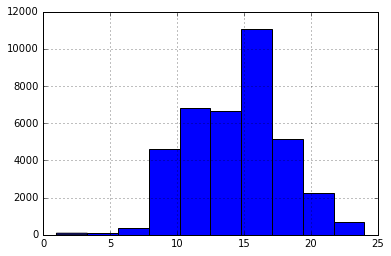

In [11]:
## Histogram by hour of the day
with_week_day['hour'].hist()

### Create 'Time of the day' flag

I tried to group the hours into different buckets. But 'office hours' seemed to work the best

In [12]:
def func(row):
    if row['hour'] in ([0,1,2,3,4,5,6,7,8,9]):
        return 'before_office_hours'
    elif row['hour'] in ([10,11,12,13,14,15,16,17]):
        return 'during_office_hours'
    elif row['hour'] in ([18,19,20,21,22,23,24]):
        return 'after_office_hours'

with_week_day['time_of_the_day'] = with_week_day.apply(func,axis=1) 

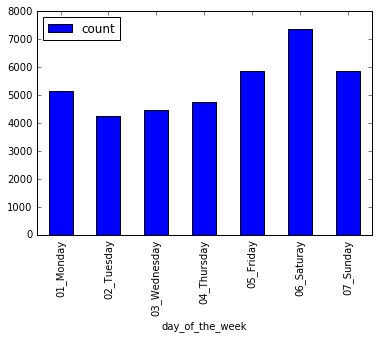

In [13]:
temp2 = with_week_day['day_of_the_week'].copy()

temp3 = pd.DataFrame(temp2.value_counts()).reset_index()
temp3.columns = ['day_of_the_week','count']
temp3.sort('day_of_the_week',inplace = True)

temp3.plot(kind='bar',x='day_of_the_week')
plt.show()

### Create Quarter flag

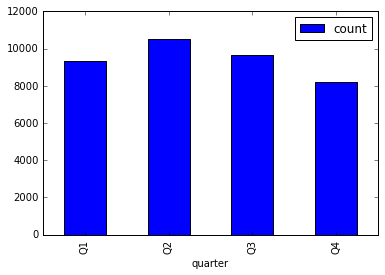

In [14]:
temp2 = with_week_day['quarter'].copy()

temp3 = pd.DataFrame(temp2.value_counts()).reset_index()
temp3.columns = ['quarter','count']
temp3.sort('quarter',inplace = True)

temp3.plot(kind='bar',x='quarter')
plt.show()

### Combine some of the features

In [27]:
data_for_modeling2 = with_week_day[['panid', 'l2', 'marketname','outlet','day_of_the_week','hour','dollars','family_size'
                                   ,'age_group_applied_to_male_hh','age_group_applied_to_female_hh','product_type',
                                  'time_of_the_day','combined_pre_tax_income_of_hh','education_level_reached_by_male_hh',
                                  'education_level_reached_by_female_hh','occupation_code_of_female_hh','occupation_code_of_male_hh',
                                  'quarter','all_tvs','cabl_tvs']]

In [16]:
data_for_modeling = data_for_modeling2.copy()

In [17]:
data_for_modeling['income_per_person'] = data_for_modeling['combined_pre_tax_income_of_hh']/(data_for_modeling['family_size']+1)
data_for_modeling['age_group'] = data_for_modeling[['age_group_applied_to_male_hh','age_group_applied_to_female_hh']].mean(axis=1)
data_for_modeling['education'] = data_for_modeling[['education_level_reached_by_male_hh','education_level_reached_by_female_hh']].mean(axis=1)
data_for_modeling['occupation'] = data_for_modeling[['occupation_code_of_male_hh','occupation_code_of_female_hh']].mean(axis=1)
data_for_modeling['number_of_tvs'] = data_for_modeling[['all_tvs','cabl_tvs']].mean(axis=1)

In [19]:
data_for_modeling[['income_per_person','age_group','education','occupation','number_of_tvs']] = data_for_modeling[['income_per_person','age_group','education','occupation','number_of_tvs']].apply(np.round,decimals=1)

### One hot encoding

In [20]:
## One hot encoding

for_one_hot = data_for_modeling[['income_per_person','dollars','outlet', 'day_of_the_week','time_of_the_day',
                                   'age_group','education','occupation','number_of_tvs'
                                ,'marketname',
                                'quarter']].copy()

for_one_hot['income_per_person'] = for_one_hot['income_per_person'].astype(str)
for_one_hot['age_group'] = for_one_hot['age_group'].astype(str)
for_one_hot['education'] = for_one_hot['education'].astype(str)
for_one_hot['occupation'] = for_one_hot['occupation'].astype(str)
for_one_hot['number_of_tvs'] = for_one_hot['number_of_tvs'].astype(str)
for_one_hot['quarter'] = for_one_hot['quarter'].astype(str)


after_one_hot = pd.get_dummies(for_one_hot)

###  Handle NANs - Peyman's code

In [22]:


def data_prep (data):
    # determining the non-numeric columns and transforming them into numeric using LabelEncoder() method
    real_or_str=data.applymap(np.isreal).all(0)
    non_num_feature=real_or_str[~real_or_str].keys()
    print "Non-numeric features are: ", non_num_feature
    le = preprocessing.LabelEncoder()
    for col in non_num_feature:
        #transform the non-numeric columns to numeric values using 
        #LabelEncoder method from SKLearn#
        data.ix[:,col]=le.fit_transform(data.ix[:,col])
    return data

In [23]:
panel_store_preped=data_prep(after_one_hot)
panel_store_preped.head()

Non-numeric features are:  Index([], dtype='object')


,dollars,income_per_person_0.0,income_per_person_0.1,income_per_person_0.2,income_per_person_0.3,income_per_person_0.4,income_per_person_0.5,income_per_person_0.6,income_per_person_0.7,income_per_person_0.8,...,number_of_tvs_6.0,number_of_tvs_6.5,number_of_tvs_7.0,number_of_tvs_9.0,marketname_EAU CLAIRE,marketname_PITTSFIELD,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,4.38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,4.28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,4.10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,3.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,2.59,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


### Split the data into test and train

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(panel_store_preped, data_for_modeling['l2'], test_size=0.2, random_state=4)
print (X_train.shape)

(30204, 122)


### Fit Decision tree

In [25]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)
dtree.score(X_test, Y_test)

0.47463912064627201

### Fit Random forest

In [26]:
tree = RandomForestClassifier()
tree.fit(X_train, Y_train)
tree.score(X_test, Y_test)

0.45212554628526025